In [2]:
import pathlib
import pandas as pd
import numpy as np
from itertools import combinations
import re
# plotting libraries
from matplotlib import pyplot as plt
import seaborn as sns
import seaborn.objects as so
from seaborn import axes_style
# machine learning libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report, accuracy_score
# stats
import statsmodels.api as sm
from statsmodels import stats as sms
import statsmodels.formula.api as smf

import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)


# Parameters

In [3]:
AF_DATA_DIR = '../data/extracted_feature_032023_afcondition_2'
BF_DATA_DIR = '../data/extracted_feature_031023_bfcondition_2'
RNG_SEED = 1

# Model performance

## Utility functions

In [37]:
def model_performance(data, rng=np.random.default_rng(0), num_shuffle=1000, classifier=LogisticRegression()):
    """
    Fit a vanilla logistic regression and report f1 score per odor and overall accuracy score through bootstrapping.
    Fitted model is not saved or returned!

    Args:
        data: pd.DataFrame  # dataframe with columns 'odor', 'exp' and a number of 'feature' columns, 'odor' column is the prediction target, columns prefixed with 'feature' will be used as predictors of the regression model, 'exp' column is kept for record keeping purposes
        rng: numpy.random._generator.Generator  # random generator used in cross validation, fix it to reproduce the same results
        num_shuffle: int  # number of shuffles to estimate variance of model performance
    Return:
        f1score_df: pd.DataFrame  # dataframe recording cross validated f1 scores, each row is one cross validation sample
        accuracy_df: pd.DataFrame  # dataframe recording cross validated accuracy scores
    """
    # split data to X and y
    X = data.filter(like="feature").to_numpy()
    y = data.odor.to_numpy()
    # data quality control
    unique_odor, counts = np.unique(y, return_counts=True)
    assert len(np.unique(counts)) == 1, "Imbalanced experimental design!"
    assert data.exp.nunique() == 1, "More than one experiment is found!"
    assert data.cond.nunique() == 1, "More than one condition is found!"
    assert data.isna().sum().sum() == 0, "NaN values found in dataset!"
    # log information about the dataset
    logging.info(
        "There are %d trials where %d odors are presented %d times",
        len(y),
        len(unique_odor),
        np.unique(counts)[0],
    )
    logging.info(
        "%d features were extracted from population neural responses",
        X.shape[1],
    )
    # configure model
    model = make_pipeline(
        StandardScaler(), classifier
    )  # classification pipeline combines a standardization step (substract by mean and divide by std) and a vanilla logistic regression model
    # estimate variance of model performance through 5x2 cross validation
    cv = StratifiedShuffleSplit(
        n_splits=num_shuffle, test_size=.5, random_state=np.random.RandomState(rng.bit_generator)
    )
    f1score = []
    accuracy = []
    f1score_train = []
    accuracy_train = []
    for train_idx, test_idx in cv.split(X, y):
        # train model on the training set
        model = model.fit(X[train_idx], y[train_idx])
        # evaluate on train set
        f1score_train.append(f1_score(y[train_idx], model.predict(X[train_idx]), average=None))
        accuracy_train.append(accuracy_score(y[train_idx], model.predict(X[train_idx])))
        # evaluate on test set
        f1score.append(f1_score(y[test_idx], model.predict(X[test_idx]), average=None))
        accuracy.append(accuracy_score(y[test_idx], model.predict(X[test_idx])))

    f1score = np.stack(f1score)
    f1score_train = np.stack(f1score_train)
    accuracy = np.stack(accuracy)
    accuracy_train = np.stack(accuracy_train)
    f1score_df = pd.DataFrame(
        data=f1score,
        index=np.arange(f1score.shape[0]),
        columns=model.classes_,
    )
    f1score_df_train = pd.DataFrame(
        data=f1score_train,
        index=np.arange(f1score_train.shape[0]),
        columns=model.classes_,
    )

    f1score_df = pd.melt(f1score_df, var_name="odor", value_name="f1_score", ignore_index=False)
    f1score_df_train = pd.melt(f1score_df_train, var_name="odor", value_name="f1_score", ignore_index=False)
    f1score_df["odor"] = pd.Categorical(f1score_df["odor"])
    f1score_df["exp"] = data.exp.unique()[0]
    f1score_df["cond"] = data.cond.unique()[0]
    f1score_df["tier"] = 'test'
    f1score_df_train["odor"] = pd.Categorical(f1score_df_train["odor"])
    f1score_df_train["exp"] = data.exp.unique()[0]
    f1score_df_train["cond"] = data.cond.unique()[0]
    f1score_df_train["tier"] = 'train'
    f1score_df = pd.concat([f1score_df, f1score_df_train])
    accuracy_df = pd.Series(accuracy).to_frame("accuracy")
    accuracy_df_train = pd.Series(accuracy_train).to_frame("accuracy")
    accuracy_df["exp"] = data.exp.unique()[0]
    accuracy_df["cond"] = data.cond.unique()[0]
    accuracy_df["tier"] = 'test'
    accuracy_df_train["exp"] = data.exp.unique()[0]
    accuracy_df_train["cond"] = data.cond.unique()[0]
    accuracy_df_train["tier"] = 'train'
    accuracy_df = pd.concat([accuracy_df, accuracy_df_train])
    return f1score_df, accuracy_df, model

## Load data

In [9]:
# random seed used for all downstream analysis
rng = np.random.default_rng(RNG_SEED)
# load all data
data = []
for filename in pathlib.Path(BF_DATA_DIR).glob('*.csv'):
    _data = pd.read_csv(filename, header=None)  # load csv file
    _data.columns = [f'feature_{i}' for i in range(len(_data.columns)-1)] + ['odor']  # rename columns
    _data['exp'] = re.findall('(?<=_).*?(?=_)', filename.stem)[0]  # log animal name
    _data['cond'] = 'before'
    data.append(_data)
    logging.info(f'loaded dataset: {BF_DATA_DIR}/{filename}')
    
for filename in pathlib.Path(AF_DATA_DIR).glob('*.csv'):
    _data = pd.read_csv(filename, header=None)  # load csv file
    _data.columns = [f'feature_{i}' for i in range(len(_data.columns)-1)] + ['odor']  # rename columns
    _data['exp'] = re.findall('(?<=_).*?(?=_)', filename.stem)[0]  # log experiment name as file name
    _data['cond'] = 'after'
    data.append(_data)
    logging.info(f'loaded dataset: {AF_DATA_DIR}/{filename}')
data = pd.concat(data)

INFO:root:loaded dataset: ../data/extracted_feature_031023_bfcondition_2/../data/extracted_feature_031023_bfcondition_2/031023_A62-1_feature_odorbfcondition.csv
INFO:root:loaded dataset: ../data/extracted_feature_031023_bfcondition_2/../data/extracted_feature_031023_bfcondition_2/031023_A60Nt_feature_odorbfcondition.csv
INFO:root:loaded dataset: ../data/extracted_feature_031023_bfcondition_2/../data/extracted_feature_031023_bfcondition_2/031023_A62Nt_feature_odorbfcondition.csv
INFO:root:loaded dataset: ../data/extracted_feature_031023_bfcondition_2/../data/extracted_feature_031023_bfcondition_2/031023_A60R1_feature_odorbfcondition.csv
INFO:root:loaded dataset: ../data/extracted_feature_032023_afcondition_2/../data/extracted_feature_032023_afcondition_2/032023_A60R1_feature_odorafcondition.csv
INFO:root:loaded dataset: ../data/extracted_feature_032023_afcondition_2/../data/extracted_feature_032023_afcondition_2/032023_A62-1_feature_odorafcondition.csv
INFO:root:loaded dataset: ../data/

In [10]:
# select columns without feature prefix
data.filter(regex='^(?!feature_)')

,odor,exp,cond
0,1,A62-1,before
1,1,A62-1,before
2,1,A62-1,before
3,1,A62-1,before
4,1,A62-1,before
...,...,...,...
35,4,A62Nt,after
36,4,A62Nt,after
37,4,A62Nt,after
38,4,A62Nt,after


## Model training

In [38]:
# train data by experiment
f1score_df = []
accuracy_df = []
models = []
for (exp, cond), _data in data.groupby(['exp', 'cond']):
    logging.info(f'Training models for {exp}, {cond} condition:')
    _data = _data.dropna(axis=1)  # drop feature columns containing nans
    _data = _data.query('odor != 1')  # remove odor 1
    _f1score_df, _accuracy_df, model = model_performance(_data, rng, classifier=LogisticRegression())
   
    f1score_df.append(_f1score_df)
    accuracy_df.append(_accuracy_df)
accuracy_df = pd.concat(accuracy_df)
f1score_df = pd.concat(f1score_df)
models.append(model)

INFO:root:Training models for A60Nt, after condition:
INFO:root:There are 30 trials where 3 odors are presented 10 times
INFO:root:120 features were extracted from population neural responses
INFO:root:Training models for A60Nt, before condition:
INFO:root:There are 30 trials where 3 odors are presented 10 times
INFO:root:120 features were extracted from population neural responses
INFO:root:Training models for A60R1, after condition:
INFO:root:There are 30 trials where 3 odors are presented 10 times
INFO:root:80 features were extracted from population neural responses
INFO:root:Training models for A60R1, before condition:
INFO:root:There are 30 trials where 3 odors are presented 10 times
INFO:root:170 features were extracted from population neural responses
INFO:root:Training models for A62-1, after condition:
INFO:root:There are 30 trials where 3 odors are presented 10 times
INFO:root:125 features were extracted from population neural responses
INFO:root:Training models for A62-1, be

In [46]:
models[0].steps[1][1].coef_.shape

(3, 165)

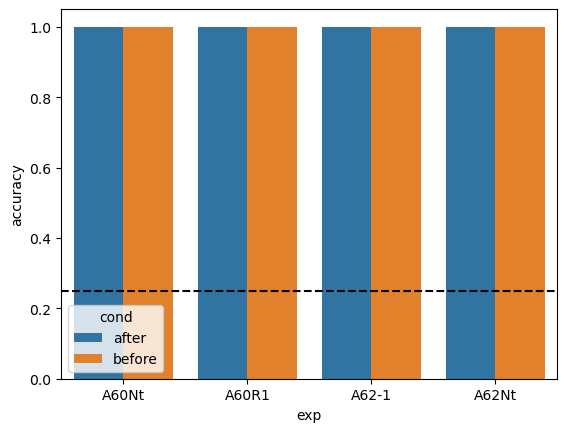

In [30]:
sns.barplot(data=accuracy_df.query('tier=="train"'), x='exp', y='accuracy', hue='cond', errorbar=("pi", 95), )
plt.axhline(1/len(np.unique(data.odor)), color='k', linestyle='--')

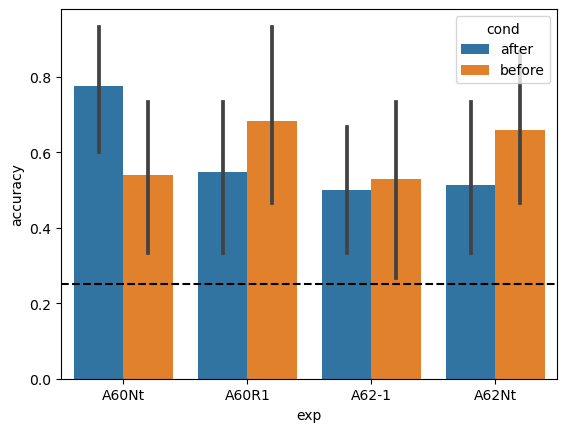

In [31]:
sns.barplot(data=accuracy_df.query('tier=="test"'), x='exp', y='accuracy', hue='cond', errorbar=("pi", 95), )
plt.axhline(1/len(np.unique(data.odor)), color='k', linestyle='--')

<Axes: xlabel='exp', ylabel='delta_accuracy'>

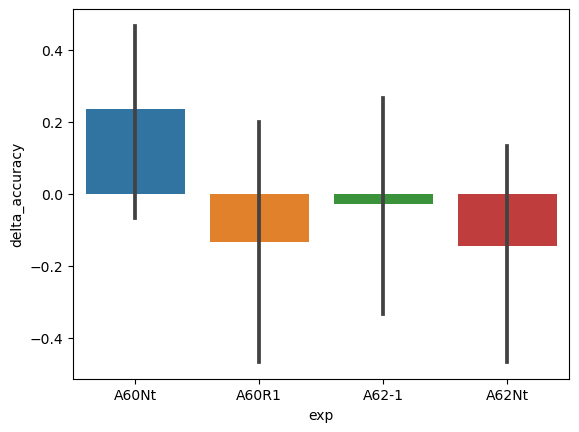

In [33]:
delta_accuracy_df = (
    accuracy_df.query('tier=="test"').reset_index()
    .query('cond == "after"')
    .merge(
        accuracy_df.query('tier=="test"').reset_index().query('cond == "before"'),
        on=["exp", "index"],
        suffixes=("_after", "_before"),
    )
)
delta_accuracy_df["delta_accuracy"] = (
    delta_accuracy_df["accuracy_after"] - delta_accuracy_df["accuracy_before"]
)
sns.barplot(
    data=delta_accuracy_df,
    x="exp",
    y="delta_accuracy",
    errorbar=("pi", 95),
)

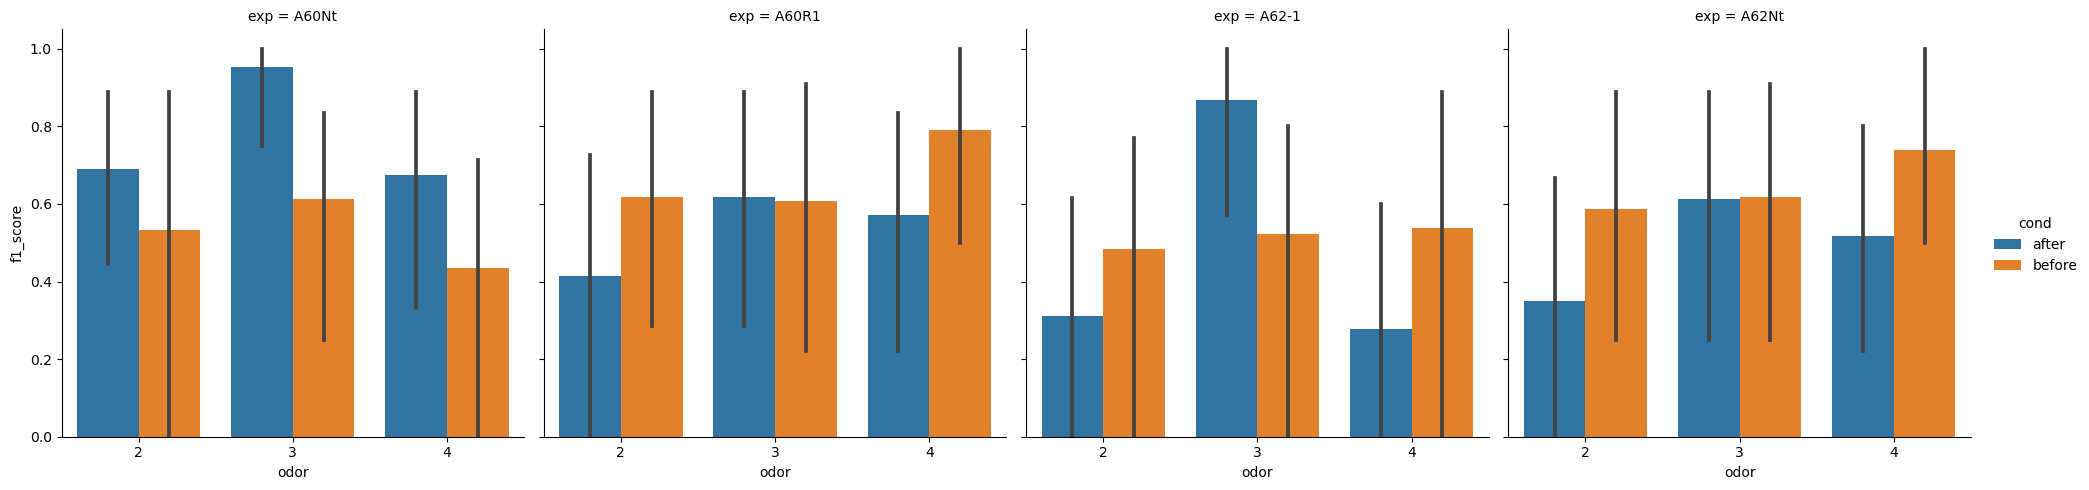

In [36]:
sns.catplot(kind='bar', data=f1score_df.query('tier=="test"'), x='odor', y='f1_score', hue='cond', col='exp', errorbar=("pi", 95), )
# plt.axhline(1/len(np.unique(data.odor)), color='k', linestyle='--')

<Axes: xlabel='exp', ylabel='delta_f1score'>

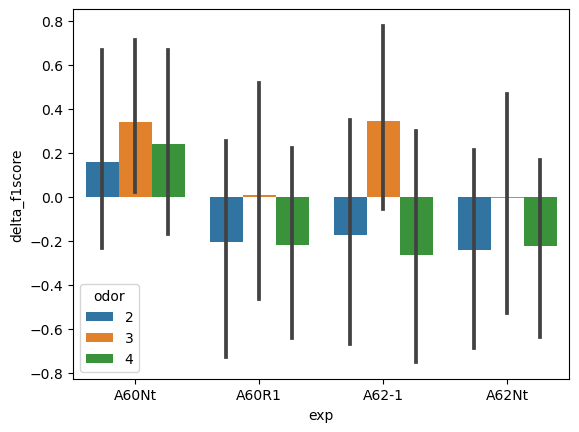

In [35]:
delta_f1score_df = (
    f1score_df.query('tier=="test"').reset_index()
    .query('cond == "after"')
    .merge(
        f1score_df.query('tier=="test"').reset_index().query('cond == "before"'),
        on=["odor", "exp", "index"],
        suffixes=("_after", "_before"),
    )
)
delta_f1score_df["delta_f1score"] = (
    delta_f1score_df["f1_score_after"] - delta_f1score_df["f1_score_before"]
)
sns.barplot(data=delta_f1score_df, x='exp', y='delta_f1score', hue='odor', errorbar=("pi", 95), )